## Import module

In [215]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pyspark.sql.functions as F
from pyspark.sql.functions import rank, sum, col, asc, desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql import Window

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.feature import PCA as PCAml
import matplotlib.mlab as mlab
from matplotlib.ticker import MaxNLocator
import itertools
import os
import missingno as msno

import findspark
findspark.init()

spark=SparkSession.builder \
        .master ("local[*]")\
        .appName("part3")\
        .getOrCreate()

sc=spark.sparkContext
sqlContext=SQLContext(sc)

c:\Users\scrmo\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [216]:
def transData(data):
    return data.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).\
           toDF(['label','features'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def get_dummy(df,categoricalCols,continuousCols,labelCol):

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

def get_dummy_unsupervised(df,categoricalCols,continuousCols):

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    return data.select('features')

## Load Data

In [217]:
df = spark.read.option("header", "true").option("sep",";").csv("XYZ_Bank_Deposit_Data_Classification.csv")

In [218]:
df = df.withColumnRenamed("emp.var.rate","emp_var_rate") \
    .withColumnRenamed("cons.price.idx","cons_price_idx") \
    .withColumnRenamed("cons.conf.idx","cons_conf_idx") \
    .withColumnRenamed("nr.employed","nr_employed") \

df = df.withColumn("age",df.age.cast('int'))
df = df.withColumn("duration",df.duration.cast('int'))
df = df.withColumn("campaign",df.campaign.cast('int'))
df = df.withColumn("pdays",df.pdays.cast('int'))
df = df.withColumn("previous",df.previous.cast('int'))
df = df.withColumn("emp_var_rate",df.emp_var_rate.cast('float'))
df = df.withColumn("cons_price_idx",df.cons_price_idx.cast('float'))
df = df.withColumn("cons_conf_idx",df.cons_conf_idx.cast('float'))
df = df.withColumn("nr_employed",df.nr_employed.cast('float'))
df = df.withColumn("euribor3m",df.euribor3m.cast('float'))

# EDA

In [219]:
df_pan = df.toPandas()

catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome', 'month', 'day_of_week']

num_cols = ['age', 'duration','campaign','pdays','previous','emp_var_rate', 
            'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

df_pan[num_cols].describe().transpose()

count         mean         std          min          25%  \
age             41188.0    40.024060   10.421250    17.000000    32.000000   
duration        41188.0   258.285010  259.279249     0.000000   102.000000   
campaign        41188.0     2.567593    2.770014     1.000000     1.000000   
pdays           41188.0   962.475454  186.910907     0.000000   999.000000   
previous        41188.0     0.172963    0.494901     0.000000     0.000000   
emp_var_rate    41188.0     0.081909    1.571047    -3.400000    -1.800000   
cons_price_idx  41188.0    93.593208    0.579143    92.200996    93.074997   
cons_conf_idx   41188.0   -40.511139    4.628254   -50.799999   -42.700001   
euribor3m       41188.0     3.621257    1.734434     0.634000     1.344000   
nr_employed     41188.0  5169.183594   72.287048  4963.600098  5099.100098   

                        50%          75%          max  
age               38.000000    47.000000    98.000000  
duration         180.000000   319.000000  4918.000000  
campaign           2.000000     3.000000    56.000000  
pdays            999.000000   999.000000   999.000000  
previous           0.000000     0.000000     7.000000  
emp_var_rate       1.100000     1.400000     1.400000  
cons_price_idx    93.749001    93.994003    94.766998  
cons_conf_idx    -41.799999   -36.400002   -26.900000  
euribor3m          4.857000     4.961000     5.045000  
nr_employed     5191.000000  5228.100098  5228.100098

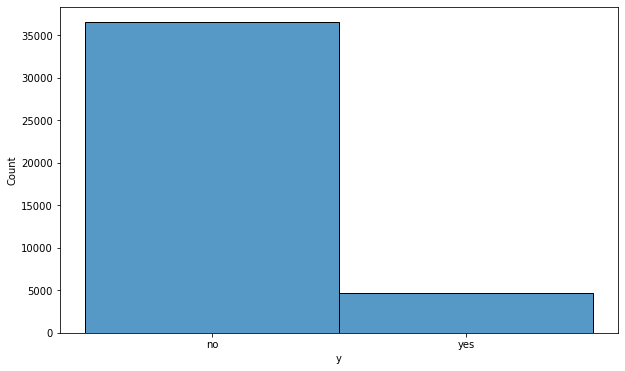

In [220]:
plt.figure(figsize=(10,6))
sns.histplot(df_pan['y'])
plt.show()

<AxesSubplot:>

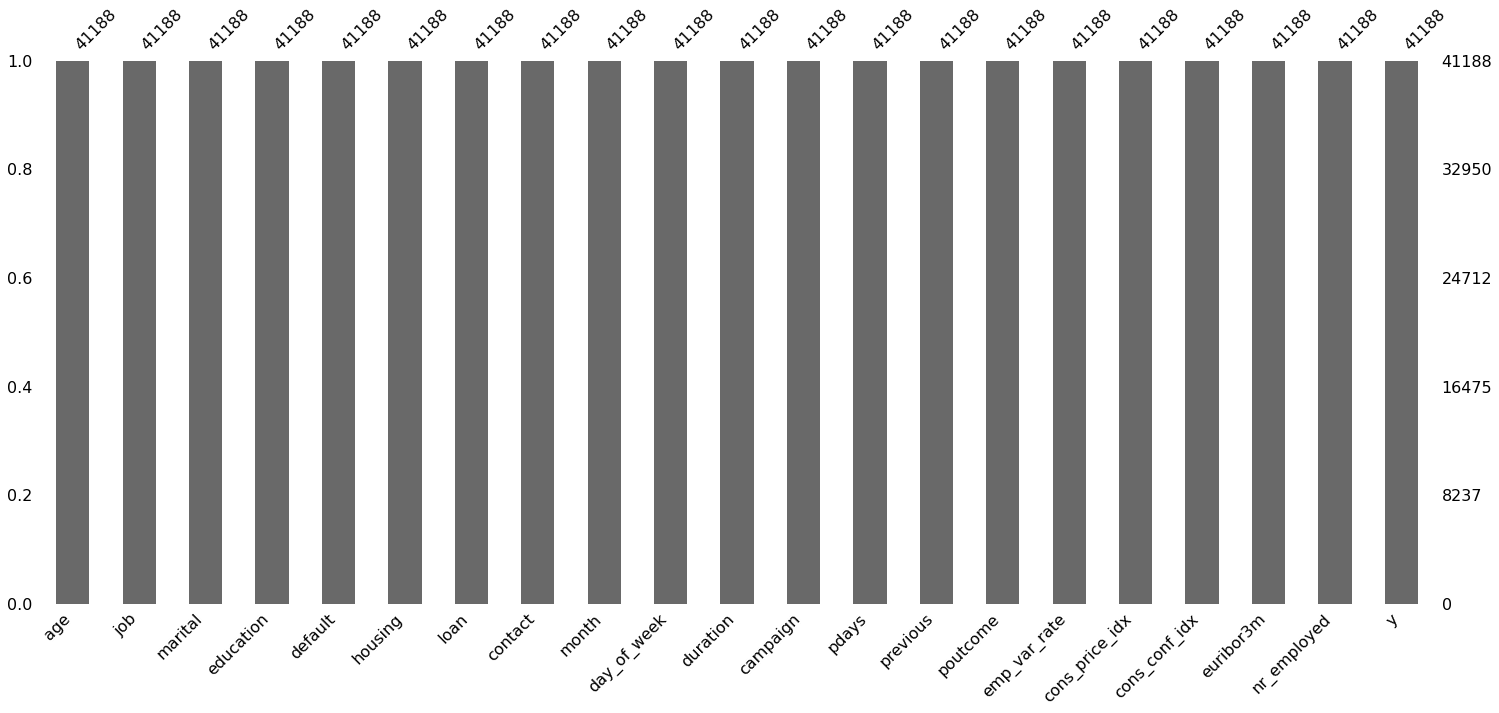

In [221]:
# Plot missing values
msno.bar(df_pan)

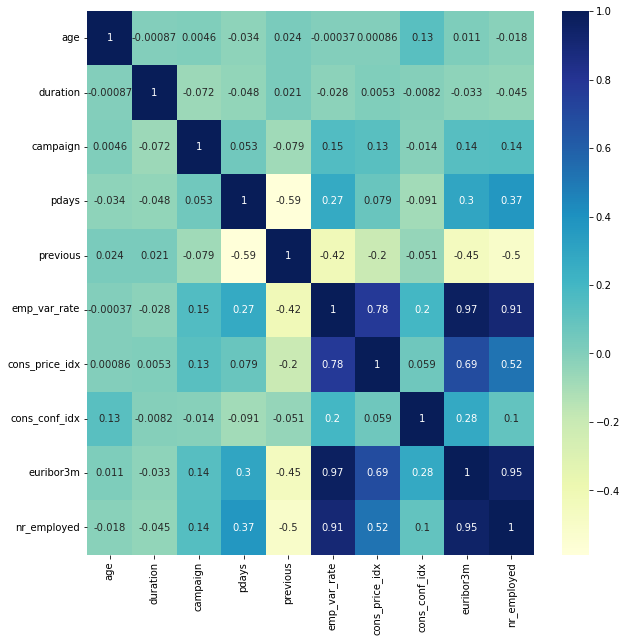

In [222]:
plt.figure(figsize=(10,10))
sns.heatmap(df_pan[num_cols].corr(), cmap="YlGnBu", annot=True)
plt.show()

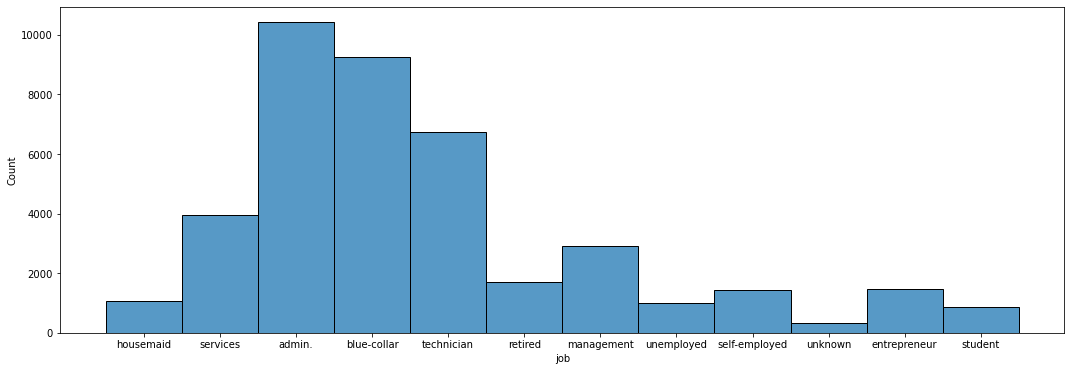

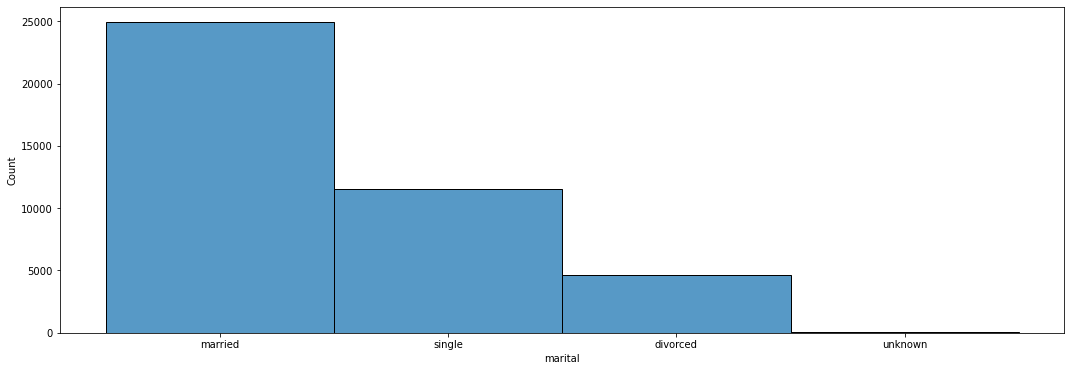

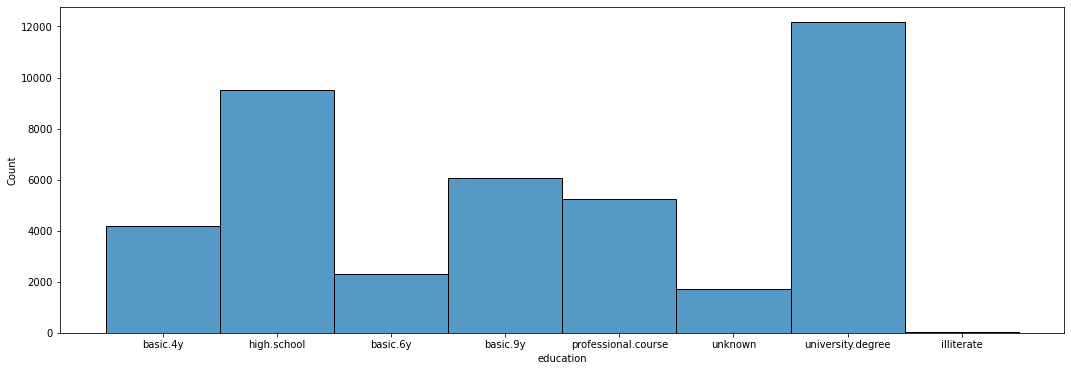

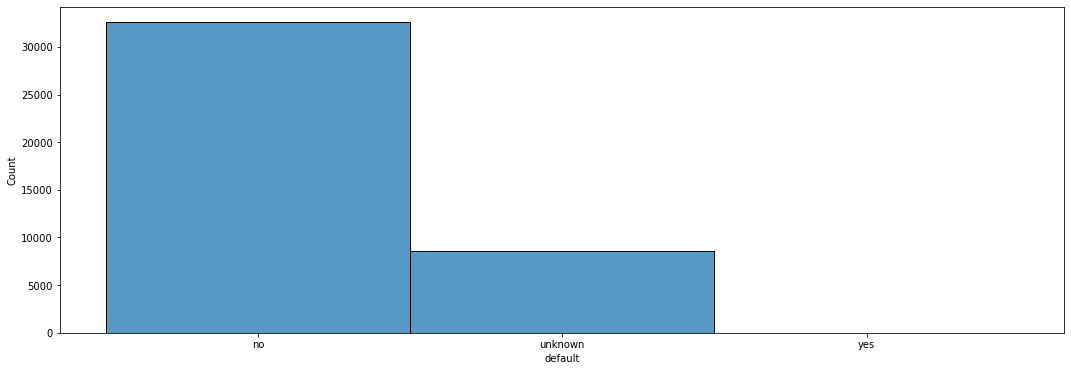

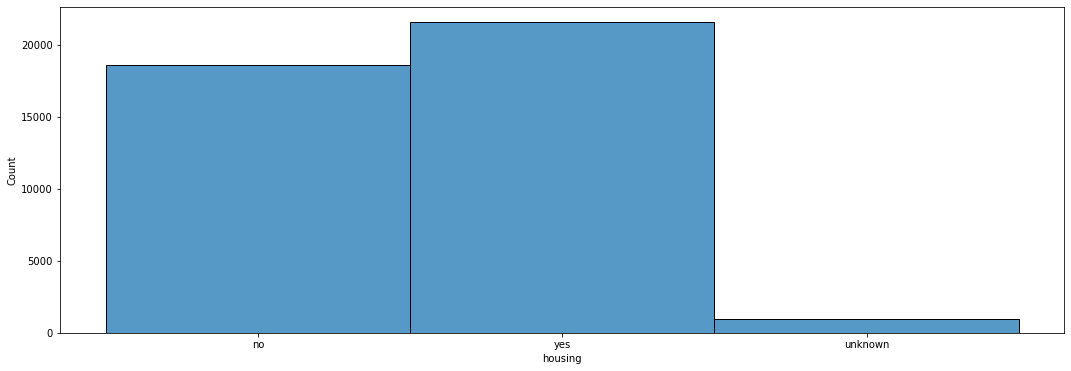

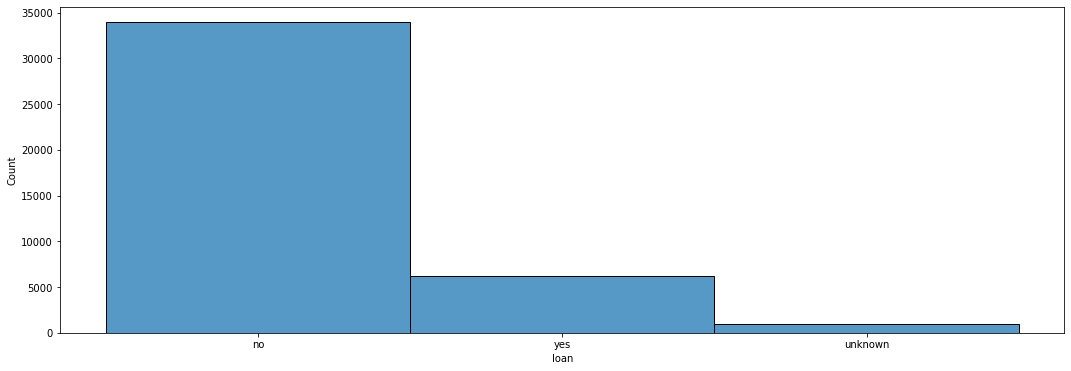

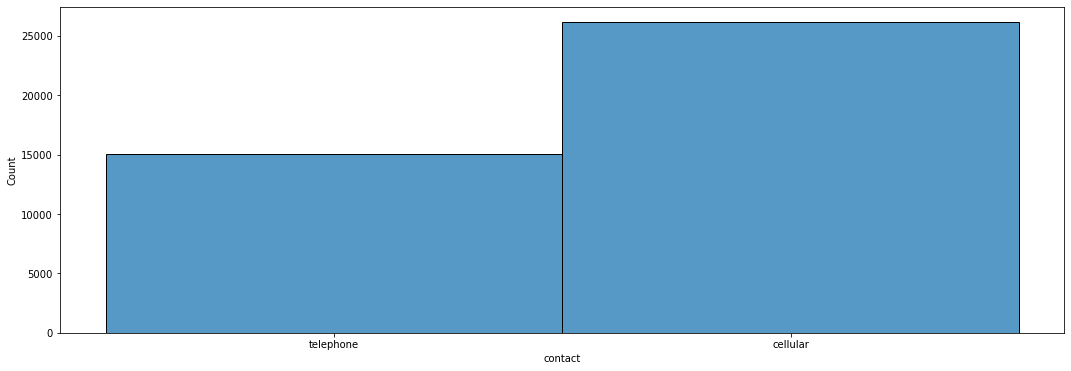

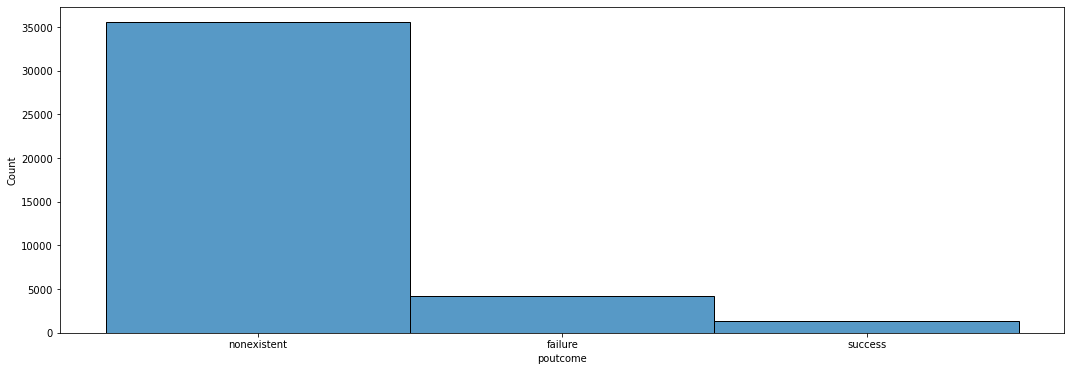

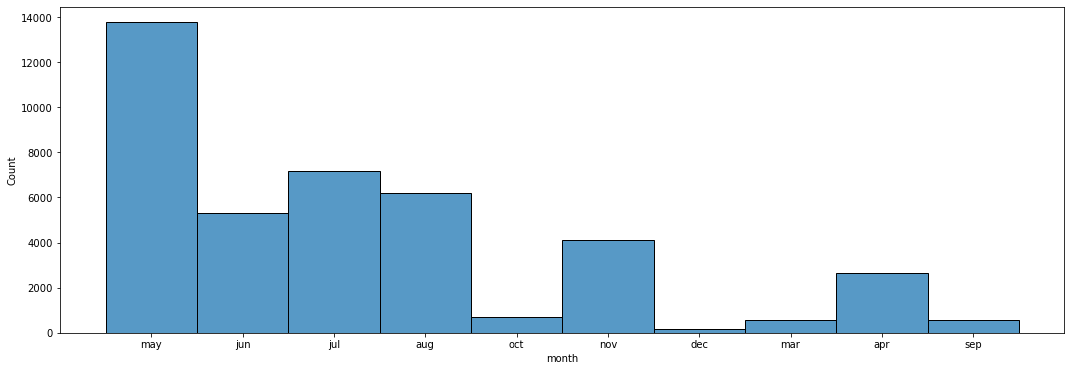

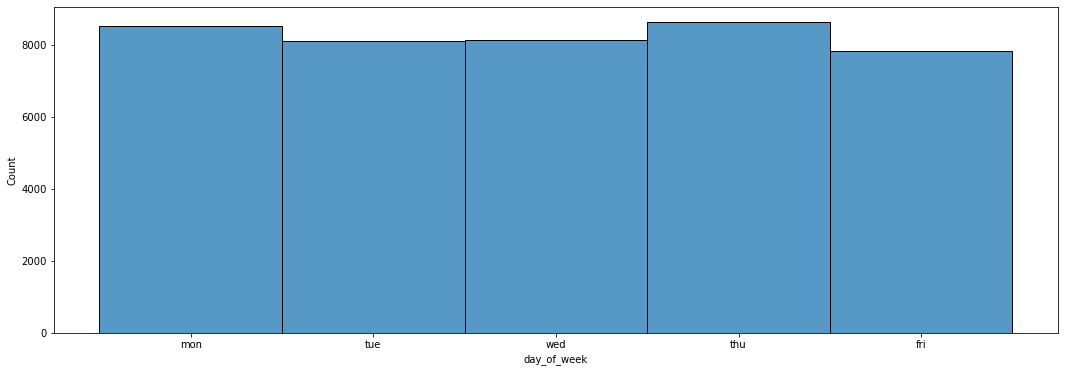

In [223]:
for i in catcols:
    plt.figure(figsize=(18,6))
    sns.histplot(df_pan[i])
    plt.show()

# Modelling

In [224]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome', 'month', 'day_of_week']

num_cols = ['age', 'duration','campaign','pdays','previous','emp_var_rate', 
            'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

labelCol = 'y'

In [225]:
data = get_dummy(df, catcols, num_cols, labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(53,[8,11,18,21,2...|   no|
|(53,[3,11,15,22,2...|   no|
|(53,[3,11,15,21,2...|   no|
|(53,[0,11,19,21,2...|   no|
|(53,[3,11,15,21,2...|   no|
+--------------------+-----+
only showing top 5 rows



In [226]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(53,[8,11,18,21,2...|   no|         0.0|
|(53,[3,11,15,22,2...|   no|         0.0|
|(53,[3,11,15,21,2...|   no|         0.0|
|(53,[0,11,19,21,2...|   no|         0.0|
|(53,[3,11,15,21,2...|   no|         0.0|
+--------------------+-----+------------+
only showing top 5 rows



In [227]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(53,[8,11,18,21,2...|   no|(53,[8,11,18,21,2...|
|(53,[3,11,15,22,2...|   no|(53,[3,11,15,22,2...|
|(53,[3,11,15,21,2...|   no|(53,[3,11,15,21,2...|
|(53,[0,11,19,21,2...|   no|(53,[0,11,19,21,2...|
|(53,[3,11,15,21,2...|   no|(53,[3,11,15,21,2...|
+--------------------+-----+--------------------+
only showing top 5 rows



## Train-Test Split

In [229]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(3,False)
testData.show(3,False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                               |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(53,[0,11,14,21,23,25,27,28,31,39,43,44,45,46,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0,51.0,1.0,999.0,1.399999976158142,93.91799926757812,-42.70000076293945,4.958000183105469,5228.10009765625]) |no   |
|(53,[0,11,14,21,23,25,27,28,31,39,43,44,45,46,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

## Logistic Regression

In [230]:
# Fit Logistic Regression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [231]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [244]:
# Save the model
model.write().overwrite().save("/model/lr_model.model")

In [ ]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



### Evaluate

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0885186


Normalized confusion matrix
[[0.97085461 0.02914539]
 [0.56758242 0.43241758]]


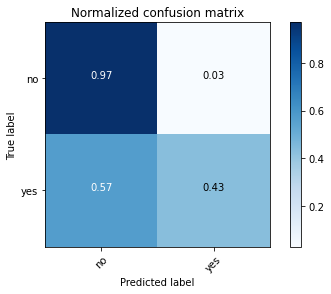

In [ ]:
# Plot normalized confusion matrix
class_names = ['no', 'yes']

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Decision Trees

In [ ]:
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [ ]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree ,labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [ ]:
# Save the model
model.write().overwrite().save("/model/dTree_model.model")

In [ ]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



### Evaluate

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.0890539
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5ad906481112, depth=5, numNodes=41, numClasses=2, numFeatures=53


Normalized confusion matrix
[[0.95832198 0.04167802]
 [0.45928685 0.54071315]]


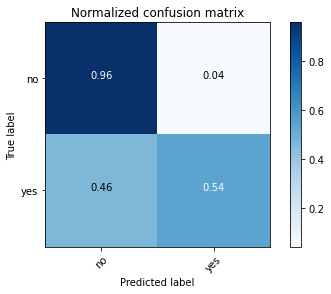

In [ ]:
class_names = ['no', 'yes']

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Random Forest    

In [ ]:
# Train a DecisionTree model
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [ ]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf ,labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [ ]:
# Save the model
model.write().overwrite().save("/model/rf_model.model")

In [ ]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



### Evaluate

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.098714
RandomForestClassificationModel: uid=RandomForestClassifier_879c6c04c88e, numTrees=20, numClasses=2, numFeatures=53


Normalized confusion matrix
[[0.99032961 0.00967039]
 [0.79457158 0.20542842]]


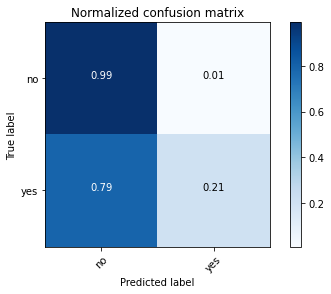

In [ ]:
class_names = ['no', 'yes']

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Gradient Boosted Trees

In [ ]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt, labelConverter])
# train the model
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [243]:
# Save the model
model.write().overwrite().save("/model/gbt_model.model")

In [ ]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



### Evaluate

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Predictions accuracy = %g, Test Error = %g" % (accuracy,(1.0 - accuracy)))

Predictions accuracy = 0.911791, Test Error = 0.0882087


Normalized confusion matrix
[[0.9645192 0.0354808]
 [0.5002661 0.4997339]]


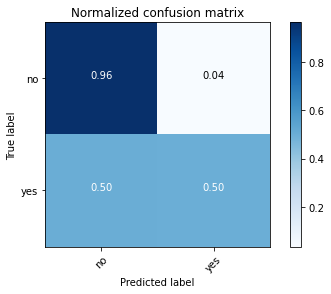

In [ ]:
class_names = ['no', 'yes']

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## K-Means

In [ ]:
df_cluster = df.drop("y")

In [ ]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome', 'month', 'day_of_week']

num_cols = ['age', 'duration','campaign','pdays','previous','emp_var_rate', 
            'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

In [ ]:
data = get_dummy_unsupervised(df_cluster, catcols, num_cols)
data.show(5)

+--------------------+
|            features|
+--------------------+
|(53,[8,11,18,21,2...|
|(53,[3,11,15,22,2...|
|(53,[3,11,15,21,2...|
|(53,[0,11,19,21,2...|
|(53,[3,11,15,21,2...|
+--------------------+
only showing top 5 rows



In [233]:
featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(data)

data = featureIndexer.transform(data)

In [234]:
data.show(5,True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(53,[8,11,18,21,2...|   no|(53,[8,11,18,21,2...|
|(53,[3,11,15,22,2...|   no|(53,[3,11,15,22,2...|
|(53,[3,11,15,21,2...|   no|(53,[3,11,15,21,2...|
|(53,[0,11,19,21,2...|   no|(53,[0,11,19,21,2...|
|(53,[3,11,15,21,2...|   no|(53,[3,11,15,21,2...|
+--------------------+-----+--------------------+
only showing top 5 rows



### Silhouette for optimal-k

In [235]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol="indexedFeatures", \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='indexedFeatures', k=K)

    KMeans_fit=KMeans_.fit(data)

    KMeans_transform=KMeans_fit.transform(data) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)


Text(0, 0.5, 'Silhouette Score')

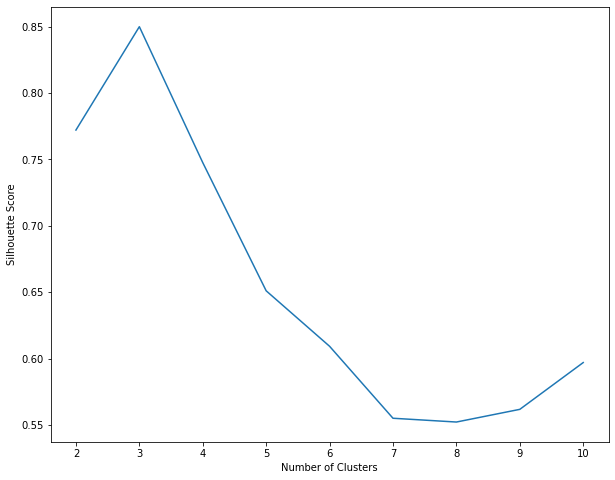

In [236]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [237]:
# Run KMeans
kmeans = KMeans() \
          .setK(3) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(data)

cluster = model.transform(data)

In [242]:
# Save the model
model.write().overwrite().save("/model/kmeans_model.model")

In [ ]:
cluster.show(50)

+--------------------+--------------------+-------+
|            features|     indexedFeatures|cluster|
+--------------------+--------------------+-------+
|(53,[8,11,18,21,2...|(53,[8,11,18,21,2...|      0|
|(53,[3,11,15,22,2...|(53,[3,11,15,22,2...|      0|
|(53,[3,11,15,21,2...|(53,[3,11,15,21,2...|      0|
|(53,[0,11,19,21,2...|(53,[0,11,19,21,2...|      0|
|(53,[3,11,15,21,2...|(53,[3,11,15,21,2...|      0|
|(53,[3,11,16,22,2...|(53,[3,11,16,22,2...|      0|
|(53,[0,11,17,21,2...|(53,[0,11,17,21,2...|      0|
|(53,[1,11,20,22,2...|(53,[1,11,20,22,2...|      0|
|(53,[2,12,17,21,2...|(53,[2,12,17,21,2...|      0|
|(53,[3,12,15,21,2...|(53,[3,12,15,21,2...|      0|
|(53,[1,11,20,22,2...|(53,[1,11,20,22,2...|      0|
|(53,[3,12,15,21,2...|(53,[3,12,15,21,2...|      0|
|(53,[1,12,15,21,2...|(53,[1,12,15,21,2...|      0|
|(53,[8,13,18,21,2...|(53,[8,13,18,21,2...|      0|
|(53,[1,11,19,21,2...|(53,[1,11,19,21,2...|      0|
|(53,[5,11,16,22,2...|(53,[5,11,16,22,2...|      0|
|(53,[1,11,1

### Visualize clusters

In [239]:
pca = PCAml(k=2, inputCol="indexedFeatures", outputCol="pca")
pca_model = pca.fit(data)
pca_transformed = pca_model.transform(data)

In [240]:
# extract the principal components
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())
# retrieve the cluster assignments from k-means assignments.
cluster_assignment = np.array(cluster.rdd.map(lambda row: row.cluster).collect()).reshape(-1,1)

<Figure size 720x720 with 0 Axes>

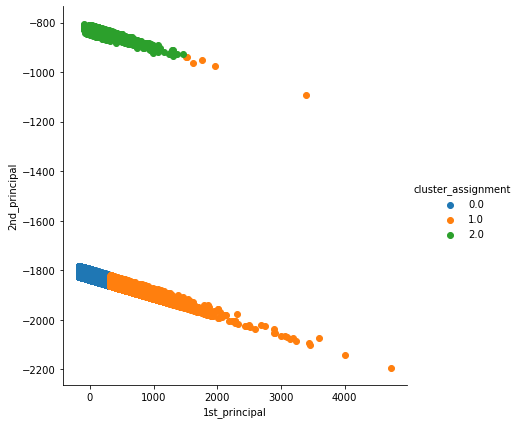

In [241]:
plt.figure(figsize = (10,10))
pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()